# CSCI-575 Theory Project
## Lewis Blake
### Paper: Confidence Intervals for Random Forests: The Jackknife and the Infinitesimal Jackknife
#### Authors: Stefan Wager, Trevor Hastie, Bradley Efron
#### Journal of Machine Learning Research 15 (2014) 1625-1651

## AutoMPG Data Experiement
Following is a recreation of the experiment performed in the paper on the AutoMPG data set. The AutoMPG data set is a supervised resgression problem. The goal is to predict automobile MPG based on seven feastures (e.g., weight and horsepower).

There is an implementation of the prediction variance estimators described in the paper in the following package, `grf` as well as in `ranger`. We will make use of both of these packages throughtout the experiments. The other packages are used in the rest of the experiments. If not presently installed, uncomment the `install.packages()` lines and run the cell. Otherwise, just load the packages.

In [2]:
#install.packages("grf")
#install.packages("dpylr")
#install.packages("ggplot2")
library(grf)
library(dplyr)
library(ggplot2)

Warning message:
“package ‘grf’ was built under R version 3.5.2”
Warning message:
“package ‘dplyr’ was built under R version 3.5.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Load the data
auto.mpg = read.csv("/Users/lewisblake/Documents/School/Mines/F19/MachineLearning/Data/TheoryProject/auto-mpg.csv")

In [4]:
# Let's look at the head of and summarize the data.
head(auto.mpg)
summary(auto.mpg)

mpg,cylinders,displacement,horsepower,weight,acceleration,model.year,origin,car.name
<dbl>,<int>,<dbl>,<fct>,<int>,<dbl>,<int>,<int>,<fct>
18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,1,buick skylark 320
18,8,318,150,3436,11.0,70,1,plymouth satellite
16,8,304,150,3433,12.0,70,1,amc rebel sst
17,8,302,140,3449,10.5,70,1,ford torino
15,8,429,198,4341,10.0,70,1,ford galaxie 500


      mpg          cylinders      displacement     horsepower      weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   150    : 22   Min.   :1613  
 1st Qu.:17.50   1st Qu.:4.000   1st Qu.:104.2   90     : 20   1st Qu.:2224  
 Median :23.00   Median :4.000   Median :148.5   88     : 19   Median :2804  
 Mean   :23.51   Mean   :5.455   Mean   :193.4   110    : 18   Mean   :2970  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:262.0   100    : 17   3rd Qu.:3608  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   75     : 14   Max.   :5140  
                                                 (Other):288                 
  acceleration     model.year        origin                car.name  
 Min.   : 8.00   Min.   :70.00   Min.   :1.000   ford pinto    :  6  
 1st Qu.:13.82   1st Qu.:73.00   1st Qu.:1.000   amc matador   :  5  
 Median :15.50   Median :76.00   Median :1.000   ford maverick :  5  
 Mean   :15.57   Mean   :76.01   Mean   :1.573   toyota corolla:  5  
 3rd Qu.:17.18   3rd Qu.:7

In [5]:
# split the data into training and testing
smp_size = floor(0.8 * nrow(auto.mpg))
set.seed(123)
train_ind = sample(seq_len(nrow(auto.mpg)), size = smp_size)
train = auto.mpg[train_ind, ]
test = auto.mpg[-train_ind, ]

X_train = train %>% select(cylinders, displacement, horsepower, weight, acceleration, model.year, origin)
X_test = test %>% select(cylinders, displacement, horsepower, weight, acceleration, model.year, origin)
y_train = train %>% select(mpg)
y_test = test %>% select(mpg)

In [6]:
# turn everything into matrix for compatability with grf functions
X_train_mat = as.matrix(sapply(X_train, as.numeric))  
y_train_mat = as.matrix(sapply(y_train, as.numeric)) 
X_test_mat = as.matrix(sapply(X_test, as.numeric)) 
y_test_mat = as.matrix(sapply(y_test, as.numeric)) 

In [7]:
# How many data points are there in the training and test data?
print(paste0("There are ", length(X_train_mat[,1]), " points in the training set."))
print(paste0("There are ", length(X_test_mat[,1]), " points in the test set."))

[1] "There are 318 points in the training set."
[1] "There are 80 points in the test set."


In [8]:
# train a random forest regression
r.forest = regression_forest(X_train_mat, y_train_mat, num.trees = 10000)

In [9]:
# predict the random forest over the training and test data
r.forest_pred = predict(r.forest, estimate.variance = TRUE)
r.forest_test = predict(r.forest, X_test_mat, estimate.variance = TRUE)

In [10]:
# check to see what predict() returns in this case since it is a 'generic' function
head(r.forest_pred) # the column variance.estimates are the ones described in the paper.

predictions,variance.estimates,debiased.error,excess.error
<dbl>,<dbl>,<dbl>,<dbl>
24.86952,0.4860020,1.2768554,0.0011299634
36.15057,0.9804882,1.0996458,0.0016523582
16.62957,0.4196693,0.3956881,0.0006722389
36.29392,1.0027780,1.9754375,0.0016124542
29.80122,1.2352705,1.4348511,0.0022234478
21.59951,0.6303022,0.3582070,0.0012023066


##### Plotting Predictions
The following plot is the predictions from the Random Forest on the AutoMPG data set trained on 318 data points and predicted over 80.

Confidence intervals of one standard error for each prediction point are superimposed on each prediction point. The dotted line represents predicted MPG versus reported MPG.

This plot is comprable to Figure 1 in the Wager et  al. paper.

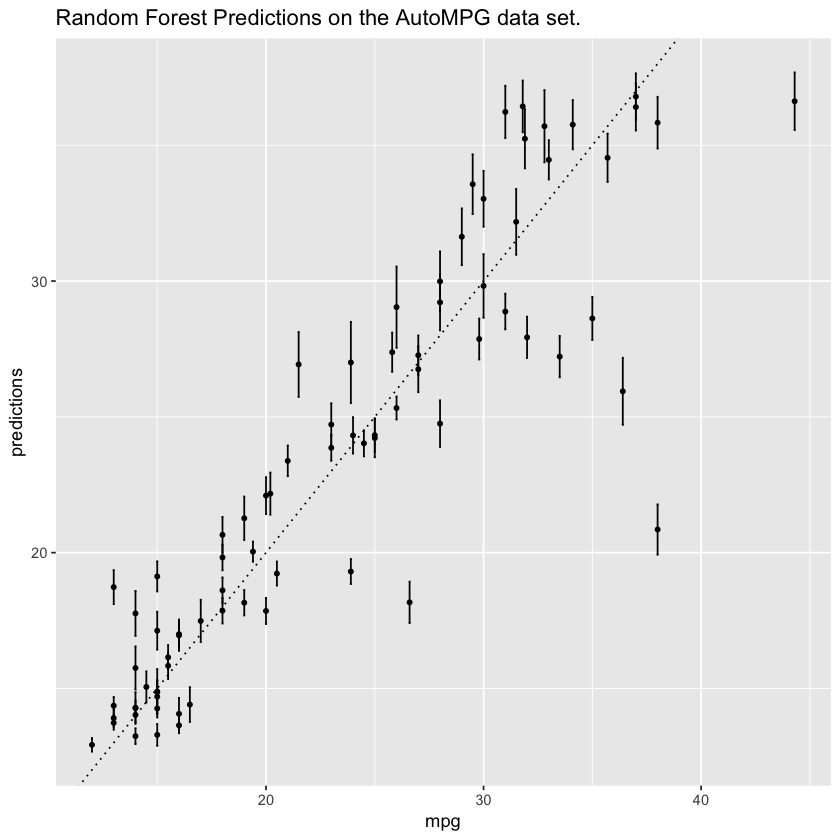

In [11]:
## Plotting predictions
# test
r.forest_test$min = r.forest_test$predictions - sqrt(r.forest_test$variance.estimates)
r.forest_test$max = r.forest_test$predictions + sqrt(r.forest_test$variance.estimates)
r.forest_test$mpg = test$mpg
ordered.test.df = r.forest_test[order(r.forest_test$predictions), ]

ggplot(ordered.test.df, aes(x = mpg,  y = predictions)) +
    geom_point(size = 1) +
    geom_errorbar(aes(ymax = max, ymin = min))+
    geom_abline(intercept = 0, lty = 3) +
    ggtitle("Random Forest Predictions on the AutoMPG data set.")

## Spambase Data Experiement
Following is a recreation of the experiment performed in the paper on the Spambase data set. The Spambase data set is a supervised classification problem. The goal is to predict spam email (1) from non-spam (0) based on 57 word frequency and character features.

The nutshell package to get the spambase data set. Either install if not already installed or load the package.

In [12]:
#install.packages("nutshell")
#install.packages("ranger")
library(nutshell)
library(ranger)

Loading required package: nutshell.bbdb

Loading required package: nutshell.audioscrobbler

Warning message:
“package ‘ranger’ was built under R version 3.5.2”


In [13]:
# load the spambase data
data(spambase)

In [14]:
# See the head of and summarize the spambase data.
head(spambase)
summary(spambase)

word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,⋯,char_freq_semicolon,char_freq_left_paren,char_freq_left_bracket,char_freq_exclamation,char_freq_dollar,char_freq_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>
0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,1


 word_freq_make   word_freq_address word_freq_all     word_freq_3d     
 Min.   :0.0000   Min.   : 0.000    Min.   :0.0000   Min.   : 0.00000  
 1st Qu.:0.0000   1st Qu.: 0.000    1st Qu.:0.0000   1st Qu.: 0.00000  
 Median :0.0000   Median : 0.000    Median :0.0000   Median : 0.00000  
 Mean   :0.1046   Mean   : 0.213    Mean   :0.2807   Mean   : 0.06542  
 3rd Qu.:0.0000   3rd Qu.: 0.000    3rd Qu.:0.4200   3rd Qu.: 0.00000  
 Max.   :4.5400   Max.   :14.280    Max.   :5.1000   Max.   :42.81000  
 word_freq_our     word_freq_over   word_freq_remove word_freq_internet
 Min.   : 0.0000   Min.   :0.0000   Min.   :0.0000   Min.   : 0.0000   
 1st Qu.: 0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.0000   
 Median : 0.0000   Median :0.0000   Median :0.0000   Median : 0.0000   
 Mean   : 0.3122   Mean   :0.0959   Mean   :0.1142   Mean   : 0.1053   
 3rd Qu.: 0.3800   3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.: 0.0000   
 Max.   :10.0000   Max.   :5.8800   Max.   :7.2700   Max.   :11.

In [15]:
# split the data into training and testing
split_size = floor(0.66 * nrow(spambase))
set.seed(123)
sb_train_ind = sample(seq_len(nrow(spambase)), size = split_size)
sb_train = spambase[sb_train_ind, ]
sb_test = spambase[-sb_train_ind, ]
# the target is_spam is the 58th column
X_train_sb = sb_train[,1:57] 
y_train_sb = sb_train[,58]
X_test_sb = sb_test[,1:57]
y_test_sb = sb_test[,58]

In [16]:
# train a classification random forest
c.forest = ranger(is_spam ~ ., data = sb_train,
                 probability = TRUE,
                 num.random.splits = 19,
                 keep.inbag = TRUE,
                 oob.error = TRUE,
                 verbose = TRUE,
                 classification = TRUE,
                 num.trees = 10000)

In [17]:
# predict the random forest over the training and test data
c.forest_pred_se = predict(c.forest, data = X_test_sb,
                          type = "se",
                          se.method = "infjack")

In [18]:
# check the predictions
head(c.forest_pred_se)
summary(c.forest_pred_se)

0,1
0.0131472806,0.9868527
0.5397488051,0.4602512
0.6289137410,0.3710863
0.1999339334,0.8000661
0.0796228846,0.9203771
0.6387259357,0.3612741
0.3065710676,0.6934289
0.0388250997,0.9611749
0.1715464580,0.8284535
0.0407027625,0.9592972


                          Length Class  Mode     
predictions               3130   -none- numeric  
num.trees                    1   -none- numeric  
num.independent.variables    1   -none- numeric  
num.samples                  1   -none- numeric  
treetype                     1   -none- character
se                        3130   -none- numeric  

In [19]:
# Create a binary variable to see if the correct prediction was made
c.forest_pred_se$correct_pred = (round(c.forest_pred_se$predictions[,1]) == y_test_sb)

In [20]:
# Determine the accuracy on the test data
accuracy = 1 - sum(c.forest_pred_se$correct_pred)/length(c.forest_pred_se$correct_pred)
print(paste0("The model has ", accuracy*100, "% accruacy on the test data. This matches the experiment from the paper."))

[1] "The model has 94.8242811501597% accruacy on the test data. This matches the experiment from the paper."


#### Plotting Predictions
Following is a recreation of Figure 4b in Wager et al. using m = 19 decision splits. Note that here I grew n = 10,000 trees, more than the paper for these parameter settings, and as a result, my Standard Deviation Estimates tend to me much smaller. Along the x-axis is the probability that a given observation belongs to class 0 (ie., is not spam).

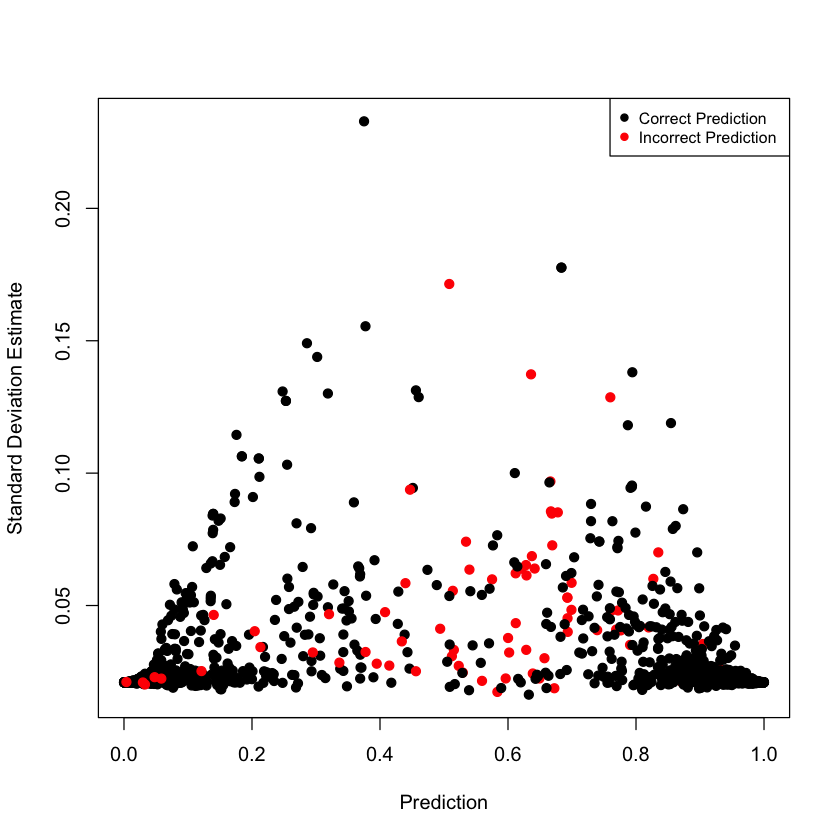

In [21]:
## Plotting predictions
plot(c.forest_pred_se$predictions[,1], c.forest_pred_se$se[,1],
    col = factor(c.forest_pred_se$correct_pred),
    pch = 19,
    xlab = "Prediction",
    ylab = "Standard Deviation Estimate")
legend("topright", legend=c("Correct Prediction", "Incorrect Prediction"),
       col=c("black", "red"), pch = 19, cex=0.8)

## Dow 30 Stock Quotes Experiment
Following is an experiement applying the estimators from Wager et al. to a new data set: the Dow 30 Stock Quotes between September 22,2008 and September 21, 2009. These data come from the `nutshell` package and contain 7482 observations of 8 features.

In [22]:
# load the dow30 data
data(dow30)

In [23]:
# See the head of and summarize the dow30 data.
head(dow30)
summary(dow30)

symbol,Date,Open,High,Low,Close,Volume,Adj.Close
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMM,2009-09-21,73.91,74.68,73.91,74.54,2560400,74.54
MMM,2009-09-18,75.12,75.25,74.50,74.62,4387900,74.62
MMM,2009-09-17,75.34,75.45,74.50,74.89,3371500,74.89
MMM,2009-09-16,74.76,75.49,74.50,75.38,2722500,75.38
MMM,2009-09-15,74.63,74.88,74.00,74.68,3566900,74.68
MMM,2009-09-14,73.72,74.64,73.42,74.56,3466400,74.56


     symbol             Date           Open             High       
 MMM    : 252   2008-09-22:  30   Min.   :  0.99   Min.   :  1.01  
 AA     : 252   2008-09-23:  30   1st Qu.: 19.66   1st Qu.: 20.19  
 AXP    : 252   2008-09-24:  30   Median : 30.16   Median : 30.75  
 T      : 252   2008-09-25:  30   Mean   : 36.25   Mean   : 36.93  
 BAC    : 252   2008-09-26:  30   3rd Qu.: 51.68   3rd Qu.: 52.45  
 BA     : 252   2008-09-29:  30   Max.   :122.45   Max.   :122.88  
 (Other):5970   (Other)   :7302                                    
      Low             Close            Volume            Adj.Close     
 Min.   :  0.27   Min.   :  0.75   Min.   :1.336e+06   Min.   :  0.75  
 1st Qu.: 19.15   1st Qu.: 19.65   1st Qu.:1.111e+07   1st Qu.: 19.38  
 Median : 29.55   Median : 30.10   Median :1.822e+07   Median : 29.41  
 Mean   : 35.53   Mean   : 36.24   Mean   :5.226e+07   Mean   : 35.64  
 3rd Qu.: 50.84   3rd Qu.: 51.58   3rd Qu.:4.255e+07   3rd Qu.: 50.97  
 Max.   :121.62   Max.  

In [24]:
# split the data into training and testing
dow_split_size = floor(0.7 * nrow(dow30))
set.seed(123)
dow_train_ind = sample(seq_len(nrow(dow30)), size = dow_split_size)
dow_train = dow30[dow_train_ind, ]
dow_test = dow30[-dow_train_ind, ]
# Note that there really could be either two targerts: closing price or adjusted closing price.
# I will try to predict the adjusted closing price, removing closing price as a feature.
X_train_dow = dow_train[, -c(6,8)] 
y_train_dow = dow_train[, 8]
X_test_dow = dow_test[,-c(6,8)]
y_test_dow = dow_test[, 8]

In [25]:
# turn everything into matrix for compatability with grf functions
X_train_dow = as.matrix(sapply(X_train_dow, as.numeric))  
y_train_dow = as.matrix(sapply(y_train_dow, as.numeric)) 
X_test_dow = as.matrix(sapply(X_test_dow, as.numeric)) 
y_test_dow = as.matrix(sapply(y_test_dow, as.numeric))

In [26]:
# How many data points are there in the training and test data?
print(paste0("There are ", length(X_train_dow[,1]), " points in the training set."))
print(paste0("There are ", length(X_test_dow[,1]), " points in the test set."))

[1] "There are 5237 points in the training set."
[1] "There are 2245 points in the test set."


In [27]:
# train a regression random forest
dow.forest = regression_forest(X_train_dow, y_train_dow, num.trees = 10000)

In [28]:
# predict the random forest over the training and test data
dow.forest_pred = predict(dow.forest, estimate.variance = TRUE)
dow.forest_test = predict(dow.forest, X_test_dow, estimate.variance = TRUE)

In [29]:
# check to see what predict() returns
head(dow.forest_pred)

predictions,variance.estimates,debiased.error,excess.error
<dbl>,<dbl>,<dbl>,<dbl>
1.342999,0.002728287,0.011428480,2.081039e-05
20.045567,0.005677771,0.008889369,2.822827e-05
13.141675,0.002646032,0.031788388,1.145859e-05
40.231655,0.015246120,0.806937196,8.659321e-05
47.608413,0.005253770,0.019128165,2.995629e-05
9.103081,0.003960417,0.008650027,1.409944e-05


##### Plotting Predictions
The following plot is the predictions from the Random Forest on the Dow30 data set trained on 5237 data points and predicted over 2245.

Confidence intervals of one standard error for each prediction point are superimposed on each prediction point. The dotted line represents predicted adjusted closing price versus reported adjusted closing price.

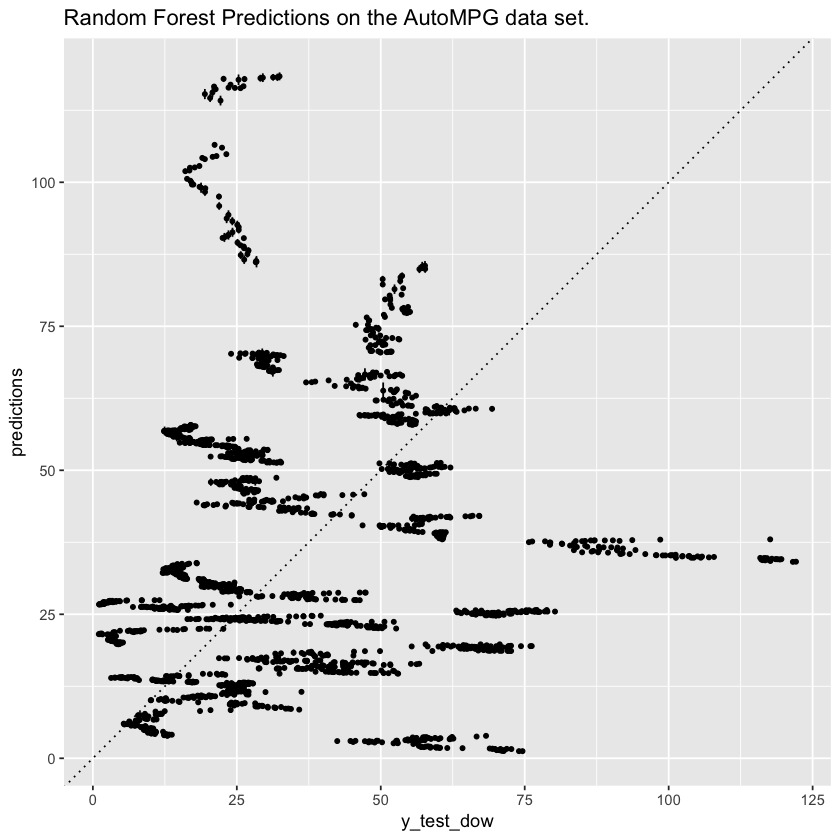

In [30]:
## Plotting predictions
# test
dow.forest_test$min = dow.forest_test$predictions - sqrt(dow.forest_test$variance.estimates)
dow.forest_test$max = dow.forest_test$predictions + sqrt(dow.forest_test$variance.estimates)
dow.forest_test$adj_close = y_test_dow
ordered.dow.test.df = dow.forest_test[order(dow.forest_test$predictions), ]

ggplot(ordered.dow.test.df, aes(x = y_test_dow,  y = predictions)) +
    geom_point(size = 1) +
    geom_errorbar(aes(ymax = max, ymin = min))+
    geom_abline(intercept = 0, lty = 3) +
    ggtitle("Random Forest Predictions on the Dow30 data set.")